### IMPORTING THE NECESSARY LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### READING THE DATA IN A DATAFRAME DF

In [2]:
df=pd.read_csv('insurance.csv')

TAKING A LOOK AT OUR DATA

In [3]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### CHECKING OUT SOME INFORMATION ABOUT THE COLUMN DATA TYPES AND NUMBER OF ROWS

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### CHECKING FOR NULL VALUES

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### SINCE THERE ARE NO NULL VALUES, NO FILLING REQUIRED

### CONVERTING THE CATEGORICAL DATA OF 'SMOKER' TO NUMERICAL FEATURES FOR USING IT IN SUITABLE FORM

In [6]:
df['smoker']=pd.get_dummies(df['smoker'],drop_first=True)

# EXPLORATORY DATA ANALYSIS

### VISUALISING A PAIRPLOT TO CHECK THE DISTRIBUTIONS OF THE FEATURES AND CORRELATION BETWEEN THEM

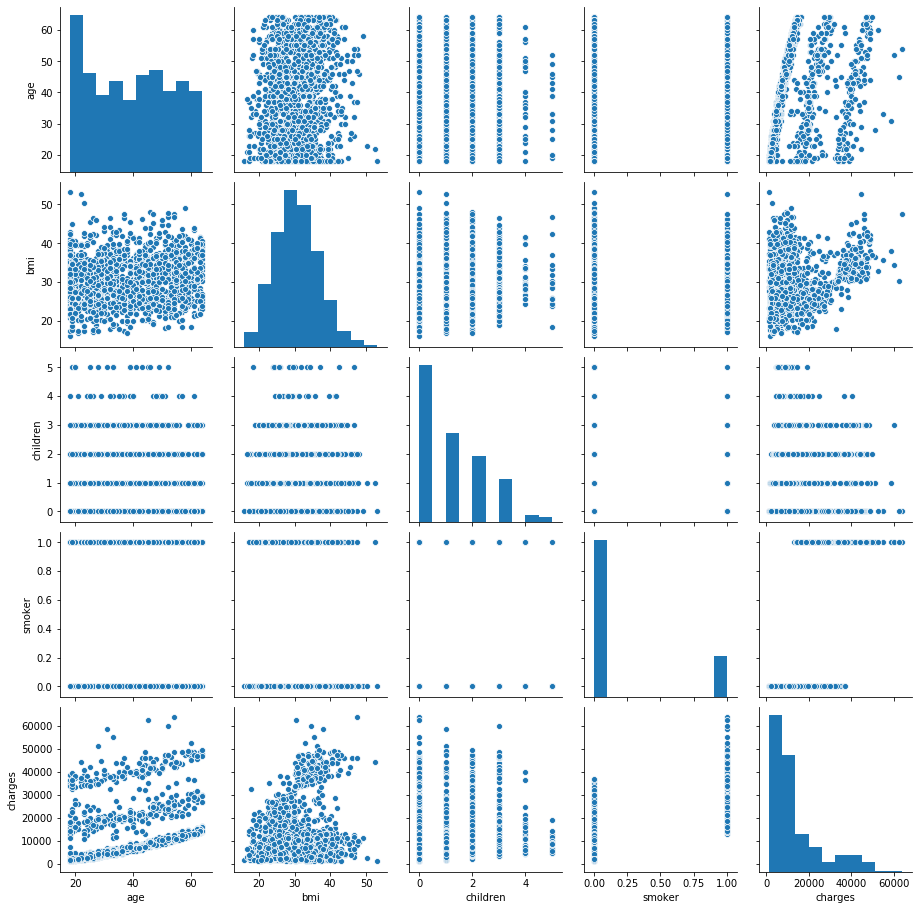

In [7]:
sns.pairplot(df)

EXPLORING THE REGION FEATURE, NUMBER OF ENTRIES IN EACH CATEGORY OF THE REGION

In [8]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

### NUMBER OF ENTRIES IN EACH CATEGORY ARE ALMOST SIMILAR, SO THIS IS A FAIR DISTRIBUTION

### LOOKING AT THE DISTRIBUTION OF THE MEDICAL CHARGES IN EACH REGION TO ANALYSE WHICH REGION IS PAYING MORE FOR MEDICAL FACILITIES

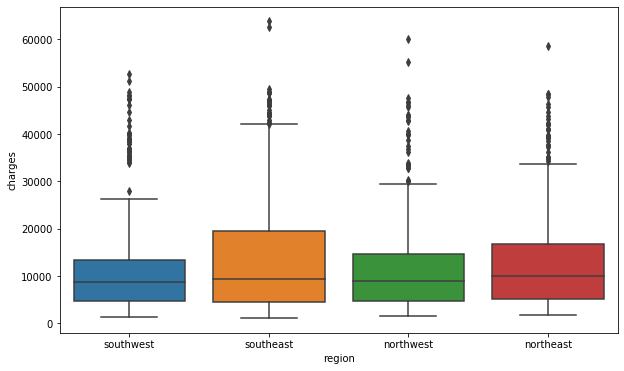

In [9]:
fig=plt.figure(figsize=(10,6))
sns.boxplot(x='region',y='charges',data=df)

### THE AVERAGE MEDICAL CHARGES FOR ALL REGIONS ARE ALMOST SIMILAR, BUT, THE SOUTHEASTERN 

### REGION OF USA HAS HIGH DISTRIBUTION OF THE MEDICAL CHARGES, DUE TO SOME REASON LIKE HIGH 

### POLLUTION IN THIS REGION.

### ANALYSING THE 'NUMBER OF CHILDREN' FEATURE AND ITS EFFECT ON MEDICAL EXPENSES

In [10]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

### THE DATA FOR FAMILES WITH 4-5 CHILDREN IS QUITE LESS

Text(0.5, 1.0, 'Number of children vs Charges')

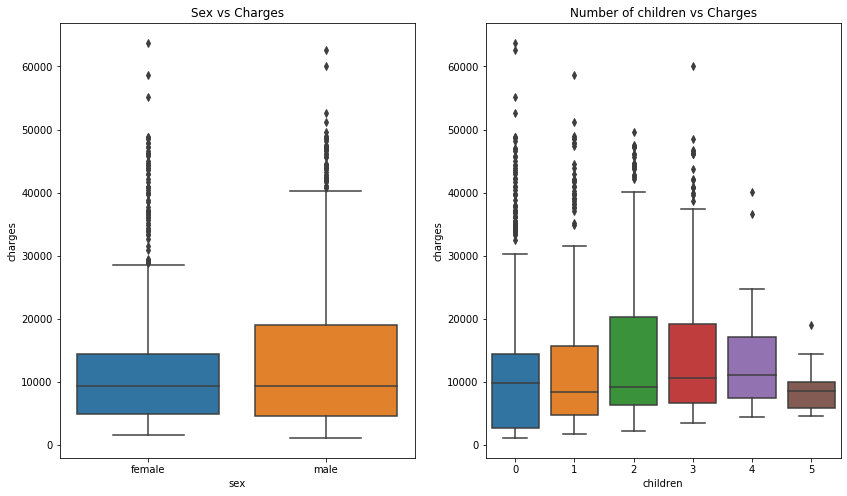

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
sns.boxplot(x = 'sex',y='charges', data = df, ax=ax[0])
ax[0].set_title('Sex vs Charges')
sns.boxplot(x = 'children',y='charges', data = df, ax=ax[1])
ax[1].set_title('Number of children vs Charges')

### IN GENERAL MALE HAVE HIGHER MEDICAL EXPENSES THAN FEMALE, AND LARGER FAMILIES HAVE NATURALLY HIGHER AVERAGE MEDICAL EXPENSES 

### BUT, THE AVERAGE AND DISTRIBUTION OF MEDICAL EXPENSES FOR VERY LARGE FAMILIES (4-5 CHILDREN) IS STILL LESS DUE TO REASONS LIKE LESSER AFFORDABILITY IN LARGE, POOR FAMILIES.

### CREATING A 'FAMILY' FEATURE TO GROUP THE FAMILIES ON THE BASIS OF NUMBER OF CHILDREN

In [12]:
df['family']=0

In [13]:
for i in range(1338):
    if (df.iloc[i,3]==0) | (df.iloc[i,3]==1):
        df.iloc[i,7]='Small'
    elif (df.iloc[i,3]==2) | (df.iloc[i,3]==3):
        df.iloc[i,7]='Medium'
    elif (df.iloc[i,3]==4) | (df.iloc[i,3]==5):
        df.iloc[i,7]='Large'    

In [14]:
df['family'].unique()

array(['Small', 'Medium', 'Large'], dtype=object)

In [15]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [16]:
df['family'].value_counts()

Small     898
Medium    397
Large      43
Name: family, dtype: int64

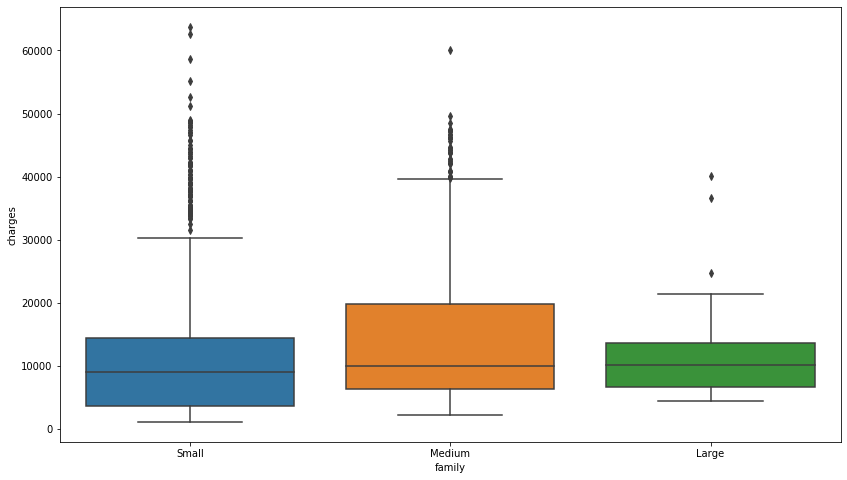

In [17]:
fig=plt.figure(figsize=(14,8))
sns.boxplot(x = 'family',y='charges', data = df)

### FAMILIES WITH 2-3 KIDS HAVE GREATER VARIABILITY AND AVERAGE MEDICAL EXPENSES, BUT LARGE FAMILIES HAVE LOWER MEDICAL EXPENSES, DUE TO REASONS STATED ABOVE

### QUANTITATIVELY EXPLORING THE DIFFERENCE BETWEEN AVERAGE CHARGES FOR DIFFERENT CATEGORICAL FEATURES

In [18]:
df.groupby('family')['charges'].mean().sort_values(ascending=False)

family
Medium    15184.988110
Small     12497.739052
Large     11730.582377
Name: charges, dtype: float64

In [19]:
df.groupby('sex')['charges'].mean().sort_values(ascending=False)

sex
male      13956.751178
female    12569.578844
Name: charges, dtype: float64

In [20]:
df.groupby('region')['charges'].mean().sort_values(ascending=False)

region
southeast    14735.411438
northeast    13406.384516
northwest    12417.575374
southwest    12346.937377
Name: charges, dtype: float64

### GRAPHICALLY EXPLORING THE CORRELATION BETWEEN DIFFERENT FEATURES WITH MEDICAL EXPENSES VIA REGRESSION PLOTS

Text(0.5, 1.0, 'Number of Children vs Charges')

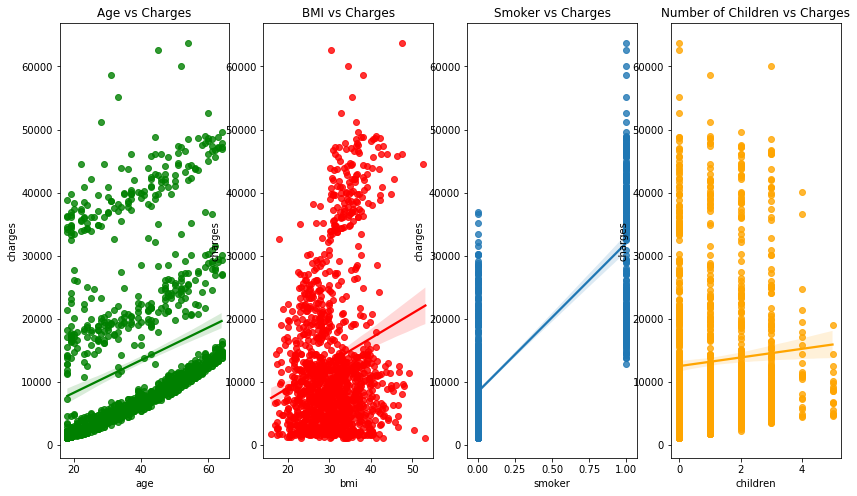

In [21]:
fig1, ax1 = plt.subplots(1,4, figsize=(14,8))
sns.regplot(x = 'age',y='charges', data = df, ax=ax1[0],color='green')
ax1[0].set_title('Age vs Charges')
sns.regplot(x = 'bmi',y='charges', data = df, ax=ax1[1],color='red')
ax1[1].set_title('BMI vs Charges')
sns.regplot(x = 'smoker',y='charges', data = df, ax=ax1[2])
ax1[2].set_title('Smoker vs Charges')
sns.regplot(x = 'children',y='charges', data = df, ax=ax1[3],color='orange')
ax1[3].set_title('Number of Children vs Charges')

### CHECKING FOR THE TOP FEATURES CORRELATED TO MEDICAL CHARGES QUANTITATIVELY AND VIA A HEATMAP

In [22]:
df.corr().drop('charges',axis=0)['charges'].sort_values(ascending=False)

smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

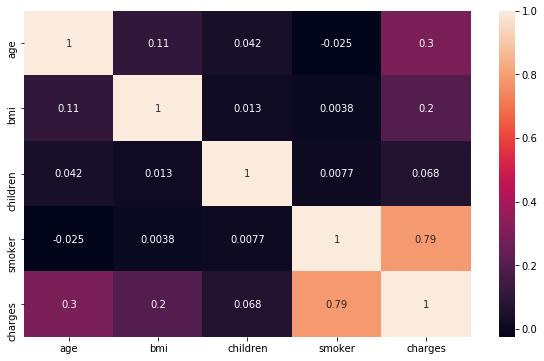

In [23]:
fig=plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True,robust=True)

### PEOPLE WHO SMOKE HAVE VERY HIGH MEDICAL EXPENSES AND THIS IS THE MOST CORRELATED FEATURE TO THE MEDICAL EXPENSES

### CHECKING FOR THE STATISTICAL SIGNIFICANCE OF THE CORRELATIONS VIA THE P-VALUES 

In [24]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker        uint8
region       object
charges     float64
family       object
dtype: object

### CARRYING OUT THE ANOVA TEST TO FIND OUT THE RELATIONSHIP BETWEEN CATEGORICAL VARIABLES AND THE MEDICAL EXPENSES

In [25]:
df_gptest = df[['smoker','sex','region','family','charges']]

In [26]:
df_gptest

,smoker,sex,region,family,charges
0,1,female,southwest,Small,16884.92400
1,0,male,southeast,Small,1725.55230
2,0,male,southeast,Medium,4449.46200
3,0,male,northwest,Small,21984.47061
4,0,male,northwest,Small,3866.85520
...,...,...,...,...,...
1333,0,male,northwest,Medium,10600.54830
1334,0,female,northeast,Small,2205.98080
1335,0,female,southeast,Small,1629.83350
1336,0,female,southwest,Small,2007.94500


In [27]:
grouped_test=df_gptest[['smoker', 'charges']].groupby(['smoker'])
grouped_test.head(2)

,smoker,charges
0,1,16884.9240
1,0,1725.5523
2,0,4449.4620
11,1,27808.7251


In [28]:
df_gptest

,smoker,sex,region,family,charges
0,1,female,southwest,Small,16884.92400
1,0,male,southeast,Small,1725.55230
2,0,male,southeast,Medium,4449.46200
3,0,male,northwest,Small,21984.47061
4,0,male,northwest,Small,3866.85520
...,...,...,...,...,...
1333,0,male,northwest,Medium,10600.54830
1334,0,female,northeast,Small,2205.98080
1335,0,female,southeast,Small,1629.83350
1336,0,female,southwest,Small,2007.94500


### CONDUCTING ANOVA TEST ON THE 'SMOKER' FEATURE

In [29]:
f_val, p_val = stats.f_oneway(grouped_test.get_group(1)['charges'], grouped_test.get_group(0)['charges'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 2177.614868056519 , P = 8.271435842182967e-283


### A SIGNIFICANTLY HIGH F-VALUE AND LOW P-VALUE (LESS  THAN 0.01) IMPLIES REJECTING THE NULL HYPOTHESIS THEORY AND ACCEPTING THE CORRELATION BETWEEN THE TWO FEATURES 'SMOKER AND CHARGES'

### CONDUCTING ANOVA TEST ON THE 'REGION' FEATURE

In [30]:
grouped_test2=df_gptest[['region', 'charges']].groupby(['region'])

In [31]:
f_val, p_val = stats.f_oneway(grouped_test2.get_group('northeast')['charges'], grouped_test2.get_group('northwest')['charges'], grouped_test2.get_group('southeast')['charges'],grouped_test2.get_group('southwest')['charges'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 2.9696266935891193 , P = 0.0308933560705201


### SINCE THE F-VALUE IS SMALL AND P-VALUE IS GREATER THAN 0.01, THIS IMPLIES, THIS IS NOT A GOOD FEATURE FOR REGRESSION MODEL, DUE TO VERY LOW CORREALATION

In [32]:
grouped_test2=df_gptest[['sex', 'charges']].groupby(['sex'])

In [33]:
f_val, p_val = stats.f_oneway(grouped_test2.get_group('male')['charges'], grouped_test2.get_group('female')['charges'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 4.3997016974374565 , P = 0.03613272100596256


### CONDUCTING ANOVA TEST ON THE 'FAMILY' FEATURE

In [34]:
grouped_test2=df_gptest[['family', 'charges']].groupby(['family'])

In [35]:
f_val, p_val = stats.f_oneway(grouped_test2.get_group('Small')['charges'], grouped_test2.get_group('Medium')['charges'], grouped_test2.get_group('Large')['charges'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 7.203265588526709 , P = 0.0007734293196849562


### SINCE THE F-VALUE IS FAIRLY GOOD AND P-VALUE IS LESS THAN 0.01, THIS IMPLIES, THIS IS A GOOD FEATURE FOR REGRESSION MODEL, DUE TO FAIRLY GOOD CORREALATION

### CREATING A STANDARD SCALER OBJECT TO NORMALISE THE DATA BEFORE APPLYING LINEAR REGRESSION

In [37]:
sc=StandardScaler()

### CREATING A COPY OF DF FOR ORIGINAL DATAFRAME DF TO STAY PROTECTED

In [38]:
dff=df

### CONVERTING CATEGORICAL FEATURE OF 'SEX' TO NUMERICAL FOR APPLICATION BY ALGORITHM

In [39]:
dff['sex']=dff['sex'].apply(lambda x:1 if x=='male' else 0)

In [40]:
dff

,age,sex,bmi,children,smoker,region,charges,family
0,19,0,27.900,0,1,southwest,16884.92400,Small
1,18,1,33.770,1,0,southeast,1725.55230,Small
2,28,1,33.000,3,0,southeast,4449.46200,Medium
3,33,1,22.705,0,0,northwest,21984.47061,Small
4,32,1,28.880,0,0,northwest,3866.85520,Small
...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,northwest,10600.54830,Medium
1334,18,0,31.920,0,0,northeast,2205.98080,Small
1335,18,0,36.850,0,0,southeast,1629.83350,Small
1336,21,0,25.800,0,0,southwest,2007.94500,Small


In [ ]:
CHECKING THE CORRELATION BETWEEN THE DIFFERNT FEATURES AND THE 'MEDICAL CHARGES' FEATURE IN DESCENDING ORDER

In [261]:
dff.corr()['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
Name: charges, dtype: float64

# MODEL DEVELOPMENT AND EVALUATION

### STORING THE PREDICTOR VARIABLE VALUES IN A VARIABLE CALLED X 

In [42]:
X=dff[['bmi','smoker','age','sex','children']]

### STORING THE MEDICAL CHARGES IN A VARIABLE Y

In [43]:
Y=dff['charges']

### PERFORMING TRAIN-TEST-SPLIT FOR SPLLITING DATA INTO TRAINING AND TESTING DATA WITH TRAINING SIZE - 70% AND TESTING SIZE - 30% OF ORIGINAL DATASET

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# LINEAR REGRESSION:

### CREATING LINEAR REGRESSION OBJECT

In [46]:
lm = LinearRegression()

### FITTING THE OBJECT WITH THE TRAINING DATA

In [47]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### STORING THE PREDICTIONS OF LINEAR REGRESSION IN A VARIABLE Y_HAT

In [48]:
Y_hat = lm.predict(X_test)

### CALCULATING THE R2 SCORE OF THE LINEAR REGRESSION MODEL ON TRAINING AND TESTING DATA

In [244]:
lr_train_r2_score=lm.score(X_train,y_train)
lm.score(X_train,y_train)

0.73028518253618

In [245]:
lr_r2_score = r2_score(y_test,Y_hat)
lr_r2_score

0.7867465671074685

### CALCULATING THE ROOT MEAN SQUARE ERROR ON THE TEST SET OF THE LINEAR REGRESSION MODEL

In [246]:
lr_rmse=np.sqrt(mean_squared_error(y_test,Y_hat))
lr_rmse

5478.857939886519

In [52]:
lr = LinearRegression()

# POLYNOMIAL REGRESSION:

### THE CLOSER THE R2 SCORE TO ONE, THE BETTER OUR MODEL

### FOR SELECTING THE DEGREE OF THE POLYNOMIAL REGRESSION MODEL, PLOTTING THE R2 SCORE FOR DIFFERENT VALUES OF THE DEGREE AND SELECTING THE ONE WITH THE HIGHEST R2 SCORE FROM 1 TO 10

Text(0.5, 1.0, 'R^2 Using Test Data')

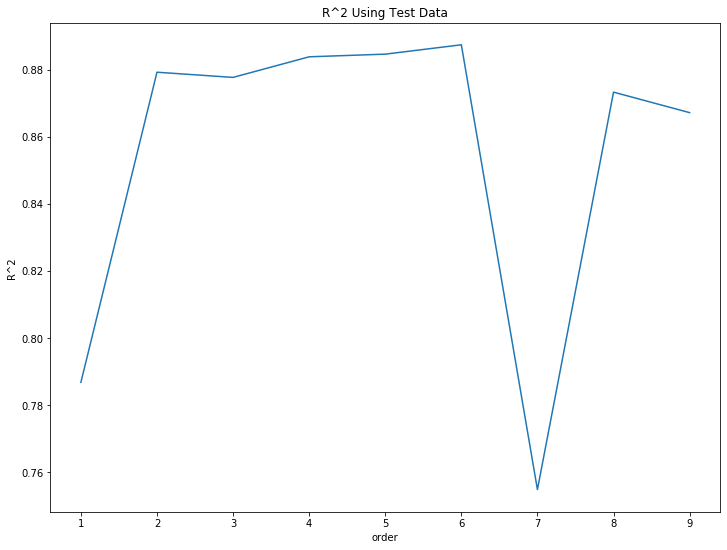

In [54]:
Rsqu_test = []

order = [num for num in range(1,10)]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(X_train)
    
    x_test_pr = pr.fit_transform(X_test)    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))
fig=plt.figure(figsize=(12,9))
plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')    

### DEGREE 6 GIVES THE MAXIMUM R2 SCORE, SELECTING IT TO MAKE A PIPELINE WHICH WILL PERFORM POLYNOMIAL REGRESSION

In [80]:
Input=[('polynomial', PolynomialFeatures(include_bias=False,degree=6)), ('model',LinearRegression())]

### CREATING A PIPELINE OBJECT

In [81]:
pipe=Pipeline(Input)
pipe

Pipeline(memory=None,
         steps=[('polynomial',
                 PolynomialFeatures(degree=6, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### FITTING THE PIPELINE OBJECT WITH THE TRAINING DATA

In [82]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('polynomial',
                 PolynomialFeatures(degree=6, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### MAKING THE PREDICTIONS ON THE TRAINING AND TESTING SET AND STORING THEM IN VARIABLES  PRED_TRAIN AND YPIPE RESPECTIVELY

In [83]:
ypipe=pipe.predict(X_test)

In [85]:
pred_train=pipe.predict(X_train)

### CALCULATING THE R2 SCORE OF THE POLYNOMIAL REGRESSION MODEL ON TRAINING AND TESTING DATA

In [247]:
pr_train_r2_score = r2_score(y_train,pred_train)
pr_train_r2_score 

0.844760342555485

In [248]:
pr_r2_score = r2_score(y_test,ypipe)
pr_r2_score

0.8873703433315301

### CALCULATING THE ROOT MEAN SQUARE ERROR ON THE TEST SET OF THE POLYNOMIAL REGRESSION MODEL

In [249]:
pr_rmse = np.sqrt(mean_squared_error(y_test,ypipe))
pr_rmse

3981.698801889921

Text(0.5, 1.0, 'Actual vs Predicted Medical Charges')

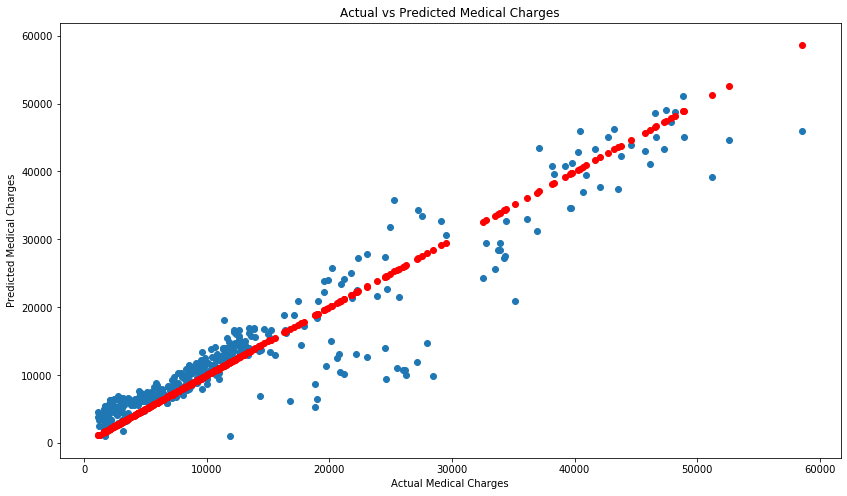

In [89]:
fig=plt.figure(figsize=(14,8))
plt.scatter(y=ypipe,x=y_test)
plt.scatter(y_test,y_test,color='r',linewidths=1)
plt.xlabel('Actual Medical Charges')
plt.ylabel('Predicted Medical Charges')
plt.title('Actual vs Predicted Medical Charges')    

### FROM THE SCATTERPLOT, IT IS EVIDENT THAT OUR MODEL DOES WELL ON PREDICTING THE MEDICAL CHARGES FOR PEOPLE WHOSE MEDICAL EXPENSES ARE BELO 15000 DOLLARS

# RIDGE REGRESSION:

### PERFORMING RIDGE REGRESSION ON THE DATASET BY FINDING THE BEST PARAMETERS THROUGH GRID SEARCH CV ON THE FOLLOWING PARAMETERS

In [91]:
parameters= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'normalize':[True,False]} ]

### CREATING A RIDGE REGRESSION OBJECT

In [92]:
RR=Ridge()
RR

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### PERFORMING GRID SEARCH ON THE PARAMETERS WITH CV VALUE AS 4

In [93]:
Grid = GridSearchCV(RR, parameters ,cv=4)

### TRANSFORMING THE TRAINING AND TESTING DATA INTO POLYNOMIAL FEATURES WITH DEGREE 6 FOR FITTING IN RIDGE REGRESSION OBJECT

In [94]:
pr2=PolynomialFeatures(degree=6)
x_train_pr=pr.fit_transform(X_train)
x_test_pr=pr.fit_transform(X_test)

### FITTING THE RIDGE REGRESSION OBJECT WITH THE TRAINING DATA

In [95]:
Grid.fit(x_train_pr, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/l

GridSearchCV(cv=4, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000],
                          'normalize': [True, False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### FINDING THE MODEL WITH THE BEST PARAMETERS

In [96]:
BestRR=Grid.best_estimator_
BestRR

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

### CALCULATING THE R2 SCORE OF THE RIDGE REGRESSION MODEL ON TRAINING AND TESTING DATA

In [252]:
RR_train_r2_score = BestRR.score(x_train_pr, y_train)
RR_train_r2_score

0.8289744986929808

In [250]:
RR_r2_score=BestRR.score(x_test_pr, y_test)
RR_r2_score

0.8784750985619123

### STORING THE PREDICTIONS OF RIDGE REGRESSION OBJECT IN A VARIABLE RR_PRED

In [98]:
rr_pred=BestRR.predict(x_test_pr)

### CALCULATING THE ROOT MEAN SQUARE ERROR ON THE TEST SET OF THE RIDGE REGRESSION MODEL

In [253]:
RR_rmse = np.sqrt(mean_squared_error(y_test,rr_pred))
RR_rmse

4135.944126084564

# XGBOOST REGRESSION:

### TRANSFORMING DATA INTO A SUITABLE FORM FOR USE BY THE XGBOOST REGRESSOR

In [101]:
data_dmatrix = xgb.DMatrix(data=X,label=Y)

### PERFORMING GRID SEARCH CV ON THE PARAMETERS OF THE XGB REGRESSOR TO FIND THE BEST ONE

In [144]:
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

# Initialize XGB and GridSearch
xgb2 = xgb.XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb2, params)
grid.fit(X_train, y_train)



[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'gamma': [0.3, 0.4, 0.5], 'max_dep

### CALCULATING THE R2 SCORE OF THE XGBOOST REGRESSION MODEL ON TRAINING AND TESTING DATA

In [255]:
xgb_train_r2_score = r2_score(y_train, grid.best_estimator_.predict(X_train))
xgb_train_r2_score

0.8583495113174975

In [254]:
xgb_r2_score = r2_score(y_test, grid.best_estimator_.predict(X_test))
xgb_r2_score

0.8989763016162411

### CALCULATING THE ROOT MEAN SQUARE ERROR ON THE TEST SET OF THE XGBOOST REGRESSION MODEL

In [256]:
xgb_rmse = np.sqrt(mean_squared_error(y_test,grid.best_estimator_.predict(X_test)))
xgb_rmse

3770.9750251931814

# NEURAL NETWORK REGRESSION:

### NORMALISING THE DATA FOR USE BY NEURAL NETWORK 

In [148]:
min_max_scaler = MinMaxScaler()

In [149]:
X_train_norm=min_max_scaler.fit_transform(X_train)

In [150]:
X_test_norm=min_max_scaler.fit_transform(X_test)

In [231]:
model=Sequential()

In [232]:
X_train.shape

(936, 4)

### CREATING THE NETWORK BY ADDING 4 LAYERS OF 4 NEURONS EACH AND RECTIFIED LINEAR UNIT AS THE ACTIVATION FUNCTION

In [233]:
model.add(Dense(4,activation="relu"))
model.add(Dense(4,activation="relu"))
model.add(Dense(4,activation="relu"))
model.add(Dense(4,activation="relu"))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

### FITTING THE MODEL WITH THE NORMALISED TRAINING DATA, TRAINING FOR 5000 EPOCHS

In [257]:
model.fit(x=X_train_norm, y=y_train, validation_data=(X_test_norm,y_test), batch_size=128,epochs=5000)

In [235]:
losses=pd.DataFrame(model.history.history)

In [236]:
losses

,loss,val_loss
0,331158592.0,302816480.0
1,331157504.0,302815456.0
2,331156384.0,302814368.0
3,331155200.0,302813184.0
4,331153984.0,302811936.0
...,...,...
4995,26335628.0,16961892.0
4996,26344864.0,17048118.0
4997,26332840.0,17017272.0
4998,26335340.0,17028000.0


### PLOTTING THE TRAINING SET AND TESTING LOSS AS A FUNCTION OF THE NUMBER OF EPOCHS 

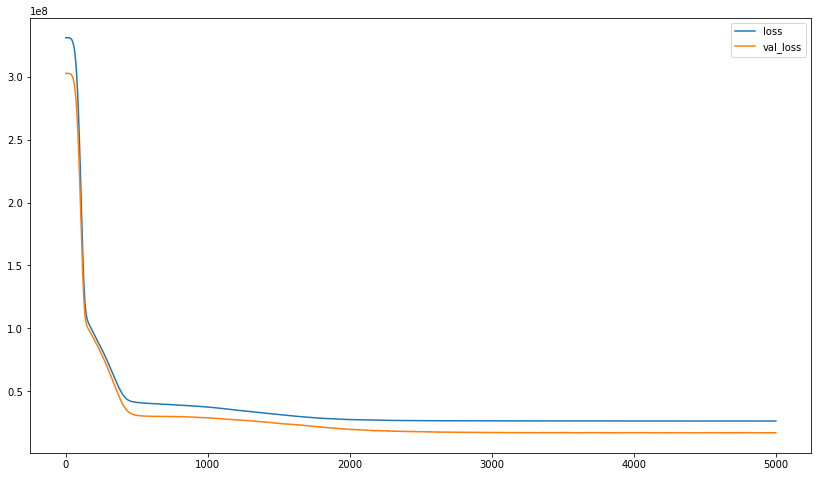

In [237]:
losses.plot(figsize=(14,8))

In [238]:
nn_pred = model.predict(X_test_norm)

In [260]:
nn_train_r2_score = r2_score(y_train,model.predict(X_train_norm))
nn_train_r2_score

0.8231136379588767

In [259]:
nn_r2_score = r2_score(y_test,nn_pred)
nn_r2_score

0.8789103065028973

In [264]:
nn_rmse = np.sqrt(mean_squared_error(y_test,nn_pred))
nn_rmse

4128.531611673513

In [279]:
print("                                         EVALUATION OF THE 5 MODELS:")
print()
print()
print("LINEAR REGRESSION:")
print()
print("r2_score on training data: "+str(lr_train_r2_score))
print("r2_score on test set: "+str(lr_r2_score))
print("root mean square error on test set: "+str(lr_rmse))
print()
print("---------------------------------------------------------------")
print()
print("POLYNOMIAL REGRESSION:")
print()
print("r2_score on training data: "+str(pr_train_r2_score))
print("r2_score on test set: "+str(pr_r2_score))
print("root mean square error on test set: "+str(pr_rmse))
print()
print()
print("---------------------------------------------------------------")
print()
print("RIDGE REGRESSION:")
print()
print("r2_score on training data: "+str(RR_train_r2_score))
print("r2_score on test set: "+str(RR_r2_score))
print("root mean square error on test set: "+str(RR_rmse))
print()
print()
print("---------------------------------------------------------------")
print()
print("XGBOOST REGRESSION:")
print()
print("r2_score on training data: "+str(xgb_train_r2_score))
print("r2_score on test set: "+str(xgb_r2_score))
print("root mean square error on test set: "+str(xgb_rmse))
print()
print()
print("---------------------------------------------------------------")
print()
print("NEURAL NETWORK REGRESSION:")
print()
print("r2_score on training data: "+str(nn_train_r2_score))
print("r2_score on test set: "+str(nn_r2_score))
print("root mean square error on test set: "+str(nn_rmse))
print()

                                         EVALUATION OF THE 5 MODELS:


LINEAR REGRESSION:

r2_score on training data: 0.73028518253618
r2_score on test set: 0.7867465671074685
root mean square error on test set: 5478.857939886519

---------------------------------------------------------------

POLYNOMIAL REGRESSION:

r2_score on training data: 0.844760342555485
r2_score on test set: 0.8873703433315301
root mean square error on test set: 3981.698801889921


---------------------------------------------------------------

RIDGE REGRESSION:

r2_score on training data: 0.8289744986929808
r2_score on test set: 0.8784750985619123
root mean square error on test set: 4135.944126084564


---------------------------------------------------------------

XGBOOST REGRESSION:

r2_score on training data: 0.8583495113174975
r2_score on test set: 0.8989763016162411
root mean square error on test set: 3770.9750251931814


---------------------------------------------------------------

NEURAL NETWORK R

# THE MODELS, ARRANGED ACCORDING TO BEST R2 SCORE AND LEAST 

# ROOT MEAN SQUARE ERROR ON TEST SET IS:

### 1. XGBOOST REGRESSOR (R2_SCORE:0.8989763016162411, RMSE:3770.9750251931814)


### 2. POLYNOMIAL REGRESSION (R2_SCORE:0.8873703433315301, RMSE:3981.698801889921)


### 3. NEURAL NETWORK REGRESSION (R2_SCORE: 0.8789103065028973, RMSE:4128.531611673513)


### 4. RIDGE REGRESSION (R2_SCORE: 0.8784750985619123, RMSE:4135.944126084564)


### 5 .LINEAR REGRESSION (R2_SCORE: 0.7867465671074685, RMSE:5478.857939886519)